<a href="https://colab.research.google.com/github/YardenGoraly/Mujoco_fun/blob/main/MuJoCo_fun.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#Initial setup, you shouldn't have to modify this code

%pip install mujoco

import platform
import os
import subprocess
import mediapy as media

# Detect the operating system and configure GPU rendering accordingly.
if platform.system() == "Linux":
    # Assume Nvidia GPU is present.
    if subprocess.run("nvidia-smi", shell=True).returncode != 0:
        raise RuntimeError(
            "Cannot communicate with GPU. Make sure you are using a GPU runtime."
        )

    # Add an ICD config so that glvnd can pick up the Nvidia EGL driver.
    NVIDIA_ICD_CONFIG_PATH = '/usr/share/glvnd/egl_vendor.d/10_nvidia.json'
    if not os.path.exists(NVIDIA_ICD_CONFIG_PATH):
        with open(NVIDIA_ICD_CONFIG_PATH, 'w') as f:
            f.write("""{
    "file_format_version" : "1.0.0",
    "ICD" : {
        "library_path" : "libEGL_nvidia.so.0"
    }
}
""")
    print("Setting environment variable for Nvidia GPU rendering (EGL).")
    os.environ["MUJOCO_GL"] = "egl"

elif platform.system() == "Darwin":
    # Assume running on macOS (Apple Silicon).
    print("Running on macOS. Setting environment variable for GPU rendering using GLFW.")
    os.environ["MUJOCO_GL"] = "glfw"

    media.set_ffmpeg("/opt/homebrew/bin/ffmpeg")
else:
    print("Unsupported platform. GPU rendering might not be configured correctly.")

# Check if MuJoCo installation was successful.
try:
    import mujoco as mj
    mj.MjModel.from_xml_string("<mujoco/>")
except Exception as e:
    raise RuntimeError(
        "Something went wrong during MuJoCo installation. Check the shell output above for more information."
    ) from e

print("MuJoCo installation successful.")

# Other imports and helper functions.
import time
import itertools
import numpy as np
np.set_printoptions(precision=3, suppress=True, linewidth=100)

# Graphics and plotting.
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.animation as animation

# On Linux, ensure ffmpeg is installed (this is not applicable on macOS).
if platform.system() == "Linux":
    !command -v ffmpeg >/dev/null || (apt update && apt install -y ffmpeg)

%pip install -q mediapy
import mediapy as media

from IPython.display import clear_output
clear_output()


In [2]:
#More setup 
%pip install robot_descriptions
%pip install dm_control

from robot_descriptions import panda_mj_description
from IPython.display import HTML
from robot_descriptions.loaders.mujoco import load_robot_description
from dm_control import mjcf
import dm_control
import PIL.Image


def display_video(frames, framerate=30):
    height, width, _ = frames[0].shape
    dpi = 70
    orig_backend = matplotlib.get_backend()
    matplotlib.use('Agg')  # Switch to headless 'Agg' to inhibit figure rendering.
    fig, ax = plt.subplots(1, 1, figsize=(width / dpi, height / dpi), dpi=dpi)
    matplotlib.use(orig_backend)  # Switch back to the original backend.
    ax.set_axis_off()
    ax.set_aspect('equal')
    ax.set_position([0, 0, 1, 1])
    im = ax.imshow(frames[0])
    def update(frame):
      im.set_data(frame)
      return [im]
    interval = 1000/framerate
    anim = animation.FuncAnimation(fig=fig, func=update, frames=frames,
                                   interval=interval, blit=True, repeat=False)
    return HTML(anim.to_html5_video())


Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [3]:
# Get XML for Sawyer, hand, and ball
ball_xml = """
<mujoco model="ball">
    <worldbody>
        <body name="ball_body" pos="0.8 0.2 0.04">
            <geom name="ball_geom" mass="0.01" friction="1" type="sphere" solref="0.01 0.5" size="0.05" rgba="1 0 0 1"/>
        </body>
    </worldbody>
</mujoco>
"""
hand_path = "mujoco_menagerie/wonik_allegro/right_hand.xml"
sawyer_path = "mujoco_menagerie/rethink_robotics_sawyer/sawyer.xml"

In [4]:
# Define Models
hand_model = mjcf.from_path(hand_path)
sawyer_model = mjcf.from_path(sawyer_path)
ball_model = mjcf.from_xml_string(ball_xml)

# Fingertips in XML are not actually at the tip, so we add a body with an offset
ff_tip = hand_model.find('body', 'ff_tip')
ff_tip.add('body', name='ff_tip_rubber', pos=[0, 0, 0.02])
ff_tip.add('site', name='ff_tip_site', pos=[0, 0, 0.02])

mf_tip = hand_model.find('body', 'mf_tip')
mf_tip.add('body', name='mf_tip_rubber', pos=[0, 0, 0.02])
mf_tip.add('site', name='mf_tip_site', pos=[0, 0, 0.02])

rf_tip = hand_model.find('body', 'rf_tip')
rf_tip.add('body', name='rf_tip_rubber', pos=[0, 0, 0.02])
rf_tip.add('site', name='rf_tip_site', pos=[0, 0, 0.02])

th_tip = hand_model.find('body', 'th_tip')
th_tip.add('body', name='th_tip_rubber', pos=[0, 0, 0.02])
th_tip.add('site', name='th_tip_site', pos=[0, 0, 0.02])

palm = hand_model.find('body', 'palm')
palm.add('site', name='palm_site', pos=[0, 0, 0])

MJCF Element: <site name="palm_site" pos="0 0 0"/>

In [5]:
# Attach hand to the Sawyer
arena = mjcf.RootElement()

import copy
ball_copy = copy.deepcopy(ball_model)
attachment_frame = arena.attach(ball_copy)


sawyer_site = sawyer_model.find('site', 'attachment_site')
# attachment_frame = arena.attach(ball_model)
sawyer_site.attach(hand_model)
arena.attach(sawyer_model)

# Set up scene
sky = arena.asset.add('texture', type='skybox', builtin="gradient", rgb1=[0, .2, 1], 
                      rgb2="1 1 1", width=512, height=512)
chequered = arena.asset.add('texture', type='2d', builtin='checker', width=500,
                            height=500, rgb1=[.2, .3, .4], rgb2=[.3, .4, .5])
grid = arena.asset.add('material', name='grid', texture=chequered,
                       texrepeat=[30, 30], reflectance=.1)
arena.worldbody.add('geom', type='plane', size=[10, 10, 10], material=grid)
for x in [-2, 2]:
  arena.worldbody.add('light', pos=[x, -1, 3], dir=[-x, 1, -2])
for y in [-2, 2]:
  arena.worldbody.add('light', pos=[-1, y, 3], dir=[1, -y, -2], attenuation=[3, 0, 0], castshadow=False)
arena.worldbody.add('camera', name='camera_1', pos=[-1, -1, 1], euler=[1.5, -0.5, 0])
arena.worldbody.add('camera', name='camera_2', pos=[-1, -1, 0.3], euler=[1.55, 2, 0])

# Add freejoint to ball so it can move freely
attachment_frame.add('joint', name='ball_joint', type='free', armature='0.00000175')

# Extract ball elements to read attributes
ball_body = ball_model.find('body', 'ball_body')
ball_geom = ball_model.find('geom', 'ball_geom')

In [28]:
# from multifingered_ik_t import LevenbergMarquardtIK


# Some util functions as suggestions, you may or may not use them
def generate_ball_contact_points(b_c : np.array, b_s: np.array):
    """
    Generates contact points for each finger on the surface of the ball
    input:
        b_c ball center coordinate in x,y,z
        b_s ball radius
    """
    f_s = np.pi/4 # finger separation
    
    #finger 1 is thumb, 2 is index, etc.
    fin1 = np.array([0,                  b_s,                0]) + b_c
    fin2 = np.array([b_s*np.sin(f_s),    b_s*np.sin(f_s),    0]) + b_c
    fin3 = np.array([b_s,                0,                  0]) + b_c
    fin4 = np.array([b_s*np.sin(f_s),   -b_s*np.sin(f_s),    0]) + b_c

    c_p = np.array([fin1, fin2, fin3, fin4]) # contact points

    return c_p
    

def calculate_ball_contact_normals(contact_points: np.array, ball_center: np.array):
    """
    Input: array of contact points
    Return: array of normal vectors on the ball for each contact
    """
    #YOUR CODE HERE
    # Vector from center to each contact
    diffs = ball_center[np.newaxis, :] - contact_points
    # Compute lengths
    norms = np.linalg.norm(diffs, axis=1, keepdims=True)
    # Avoid division by zero (if any point exactly at center)
    norms = np.where(norms == 0, 1.0, norms)
    # Normalize
    normals = diffs / norms
    return normals


def set_camera_position(physics, camera_name, camera_position):
    camera_id = physics.model.name2id(camera_name, "camera")
    physics.named.model.cam_pos[camera_name] = camera_position
    return camera_id

def set_initial_configuration(physics):
    initial_qpos = [0, 0, 0, 0, 0, 0, 0, 0, -0.8, 0, 2, 0, -1.2, 3.2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
    physics.data.qpos[:] = initial_qpos

[0.8  0.2  0.04]
0.05


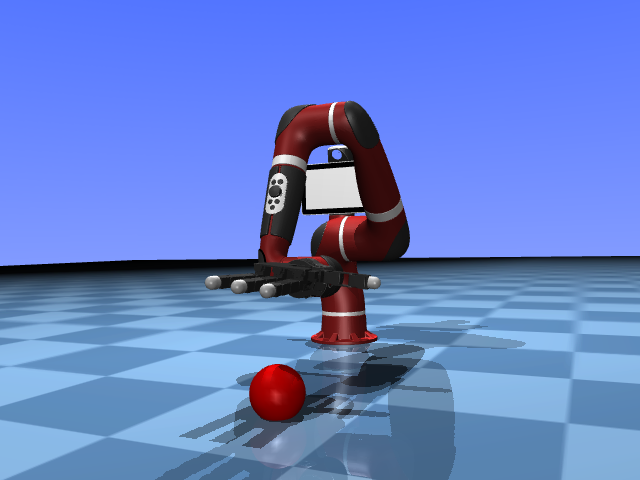

In [99]:
# Define ball attributes
ball_radius = ball_geom.size[0]
ball_center = np.array(ball_body.pos)

print(ball_center)
print(ball_radius)

physics = mjcf.Physics.from_mjcf_model(arena)

# Init scene
camera_id = set_camera_position(physics, "camera_1", [0.3, -0.5, 0.1])
camera_id2 = set_camera_position(physics, "camera_2", [1.7, 0.7, 0.3])
set_initial_configuration(physics)

physics.forward()
PIL.Image.fromarray(physics.render(height=480, width=640, camera_id=camera_id2))

In [109]:
# automate iteration for each finger, set default value for site name and joint name
from multifingered_ik_13 import *
from scipy.spatial.transform import Rotation as R 
from utils import *

from dm_control.mujoco.wrapper.mjbindings import enums
from dm_control import mujoco

site_names = ['sawyer/allegro_right/palm_site', 'sawyer/allegro_right/ff_tip_site', 'sawyer/allegro_right/mf_tip_site', 'sawyer/allegro_right/rf_tip_site', 'sawyer/allegro_right/th_tip_site']
joints_names = [['sawyer/right_j0','sawyer/right_j1','sawyer/right_j2','sawyer/right_j3','sawyer/right_j4','sawyer/right_j5','sawyer/right_j6'],
                ['sawyer/allegro_right/ffj0', 'sawyer/allegro_right/ffj1', 'sawyer/allegro_right/ffj2', 'sawyer/allegro_right/ffj3'],
                ['sawyer/allegro_right/mfj0', 'sawyer/allegro_right/mfj1', 'sawyer/allegro_right/mfj2', 'sawyer/allegro_right/mfj3'],
                ['sawyer/allegro_right/rfj0', 'sawyer/allegro_right/rfj1', 'sawyer/allegro_right/rfj2', 'sawyer/allegro_right/rfj3'],
                ['sawyer/allegro_right/thj0', 'sawyer/allegro_right/thj1', 'sawyer/allegro_right/thj2', 'sawyer/allegro_right/thj3']]

def palm_finger_ik (physics, goal_pos, goal_quat, site_name = site_names, joint_names = joints_names):
    for i in range(len(goal_pos)):
        qpos, error, steps, success = qpos_from_pose(physics, site_name[i], goal_pos[i], goal_quat[i],
                                                    joint_names[i],
                                                    tol=1e-3,
                                                    rot_weight=1.0,
                                                    regularization_threshold=0.1,
                                                    regularization_strength=3e-2,
                                                    max_update_norm=2.0,
                                                    progress_thresh=20.0,
                                                    max_steps=1000,
                                                    inplace=False)
        
        print ("iteration", i, "success", success)

        qpos_clip = clip_to_valid_state(physics, qpos)
        with physics.reset_context():
            physics.data.qpos = qpos_clip    

    return qpos, error, steps, success



iteration 0 success True
iteration 1 success True
iteration 2 success True
iteration 3 success True
iteration 4 success True


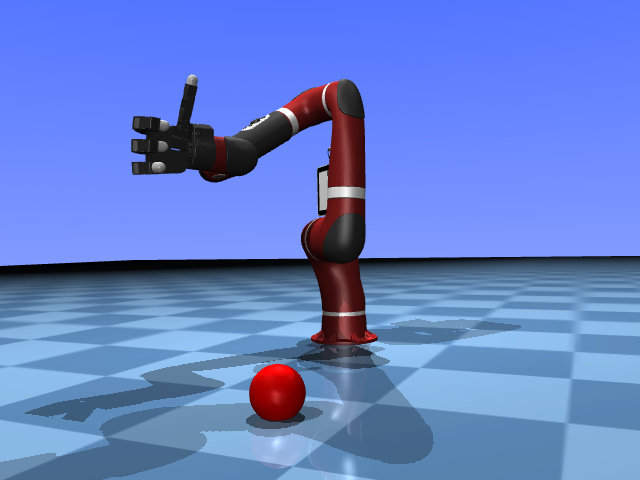

In [110]:
# thumbs up pose
goal_pos_task1 = [[ 0.674, -0.185, 0.524], [ 0.723, -0.113, 0.56 ], [ 0.723, -0.118,0.516], [ 0.736, -0.113, 0.469], [ 0.601, -0.143, 0.67 ]]
goal_quat_task1 = [[-0.626, -0.589, -0.392, -0.329], [ 0.33 , 0.305, -0.676,-0.584], [ 0.347, 0.286, -0.652, -0.61 ], [ 0.017, -0.071, -0.724, -0.686], [-0.967,0.061, 0.029, 0.245]]

palm_finger_ik(physics, goal_pos_task1, goal_quat_task1)

pixels = physics.render(height=480, width=640, camera_id=camera_id2)
PIL.Image.fromarray(pixels)


In [ ]:


q = vector_to_quaternion(np.array([0,0,-1]))
print(q)

[nan nan nan nan]


/var/folders/cz/6q2n15f56q9cxw5nb32f8r800000gn/T/ipykernel_42158/714942993.py:10: RuntimeWarning: invalid value encountered in divide
  axis_of_rotation = axis_of_rotation / np.linalg.norm(axis_of_rotation) # Step 4: Normalize the axis of rotation (to ensure it's a unit vector)


goal pos [[0.8   0.25  0.04 ]
 [0.835 0.235 0.04 ]
 [0.85  0.2   0.04 ]
 [0.835 0.165 0.04 ]]
goal orient [[ 0.    -1.     0.   ]
 [-0.707 -0.707  0.   ]
 [-1.     0.     0.   ]
 [-0.707  0.707  0.   ]]
iteration 0 success True
iteration 1 success False
iteration 2 success True
iteration 3 success False
iteration 4 success False


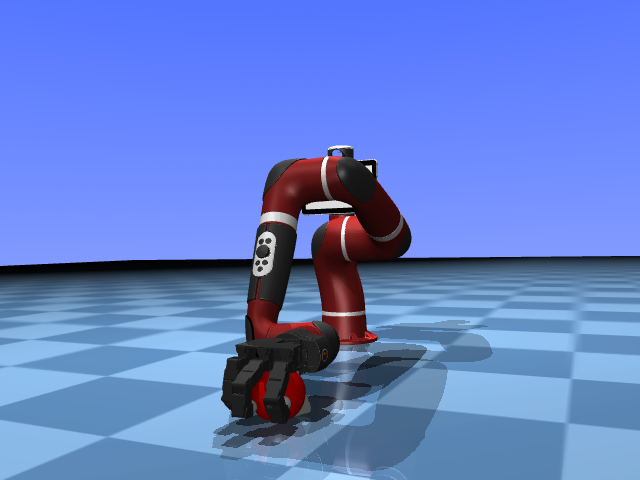

In [ ]:
# grab ball pose

# goal_pos_grab = [[0.8  0.3  0.04], [0.8   0.25  0.04 ]]
# goal_pos_grab = [[0.8,  0.3,  0.2]]
# goal_quat_grab = [[1,0,0,0]] # quaternion for 90 degree rotation around x-axis

# goal_pos_grab = [[ 0.85, 0.2, 0.1],[0.85, 0.25,0.04]]
# calculate goal finger positions
goal_pos = generate_ball_contact_points(ball_center, ball_radius)
goal_orient = calculate_ball_contact_normals(goal_pos, ball_center)

print ("goal pos", goal_pos)
print ("goal orient", goal_orient)

c_l = 0.05*np.sin(np.pi/4)
r = 0.05

goal_pos_grab = [[ 0.85, 0.2, 0.1],[0.85+c_l, 0.2+c_l,0.04],[0.9, 0.2,0.04],[0.85, 0.15,0.04],[0.85-c_l, 0.2+c_l,0.04]]
goal_quat_grab = [[np.sqrt(2)/2,0,np.sqrt(2)/2,0],[1,0,0,0],[np.sqrt(2)/2,0,-np.sqrt(2)/2,0],[1,0,0,0],[np.sqrt(2)/2,0,0,np.sqrt(2)/2]]

palm_finger_ik(physics, goal_pos_grab, goal_quat_grab)

pixels = physics.render(height=480, width=640, camera_id=camera_id2)
PIL.Image.fromarray(pixels)


In [13]:
from AllegroHandEnv import AllegroHandEnvSphere
from grasp_synthesis import synthesize_grasp

# Run grasp synthesis algorithm to generate force closure hand onfiguration

In [14]:
# Here are some flags you can set to visualize contact forces
# We suggest that you visualize the results of your grasp synthesis algorithm when debugging
# Visualize contact frames and forces, make body transparent
options = mj.MjvOption()
mj.mjv_defaultOption(options)
options.flags[mj.mjtVisFlag.mjVIS_CONTACTPOINT] = False
options.flags[mj.mjtVisFlag.mjVIS_CONTACTFORCE] = False
options.flags[mj.mjtVisFlag.mjVIS_TRANSPARENT] = False

# tweak scales of contact visualization elements
physics.model.ptr.vis.scale.contactwidth = 0.1
physics.model.ptr.vis.scale.contactheight = 0.03
physics.model.ptr.vis.scale.forcewidth = 0.05
physics.model.ptr.vis.map.force = 0.05

/var/folders/cz/6q2n15f56q9cxw5nb32f8r800000gn/T/ipykernel_36842/897899858.py:47: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  ax[2].set_yscale('log')


Text(0, 0.5, 'Newton')

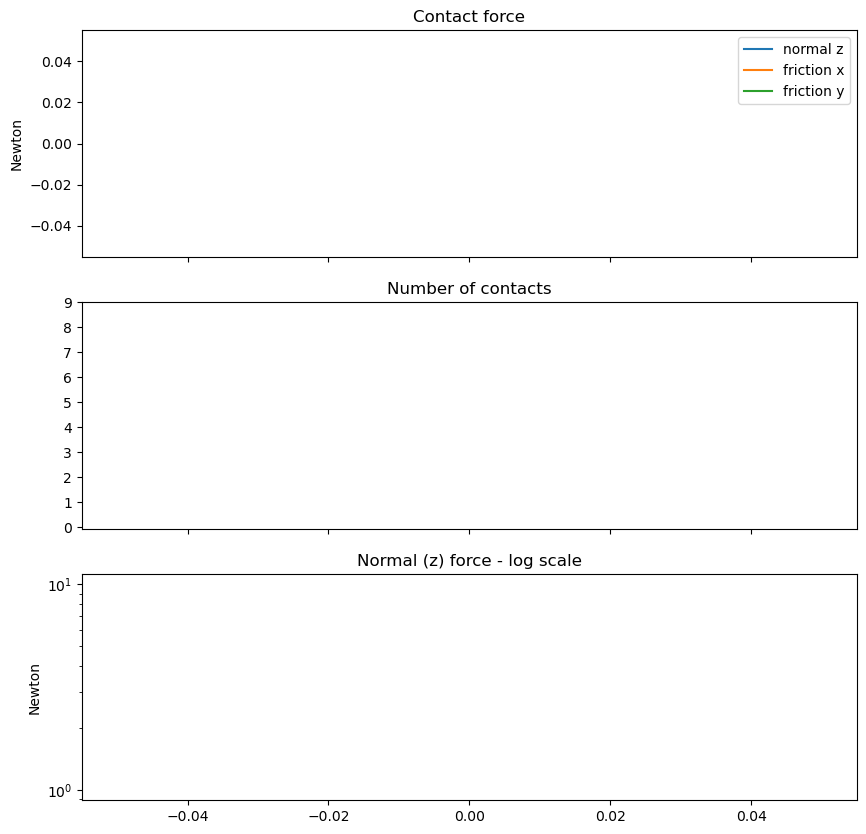

In [15]:
# Here's some skeleton code to run a control loop in MuJoCo
# This is just an initial suggestion, so feel free to change anything about it

duration = 5
framerate = 30
dt = 1 / (duration * framerate)
video = []
n_steps = 200

# allocate
sim_time = np.zeros(n_steps)
ncon = np.zeros(n_steps)
force = np.zeros((n_steps,3))
forcetorque = np.zeros(6)

physics.reset()

# Initialize state
#YOUR CODE HERE

# Run control loop
with mj.Renderer(physics.model.ptr, 480, 640) as renderer:
    for i in range(n_steps):
        while physics.data.time * framerate < i:
            # Control robot and collect data for plotting
            #YOUR CODE HERE

            physics.step()
        # Render scene, feel free to change camera
        renderer.update_scene(physics.data.ptr, "camera_2", options)
        frame = renderer.render()
        video.append(frame)

# Plot
# This is just to serve as an example for plotting. You'll likely have to make some changes for the deliverables
_, ax = plt.subplots(3, 1, sharex=True, figsize=(10, 10))

lines = ax[0].plot(sim_time, force)
ax[0].set_title('Contact force')
ax[0].set_ylabel('Newton')
ax[0].legend(list(lines), ('normal z', 'friction x', 'friction y'))
ax[1].plot(sim_time, ncon)
ax[1].set_title('Number of contacts')
ax[1].set_yticks(range(10))

ax[2].plot(sim_time, force[:,0])
ax[2].set_yscale('log')
ax[2].set_title('Normal (z) force - log scale')
ax[2].set_ylabel('Newton')


In [16]:
# Display video
media.show_video(video, fps=30)

RuntimeError: Program '/opt/homebrew/bin/ffmpeg' is not found; perhaps install ffmpeg using 'apt install ffmpeg'.